# This notebook is to demostrate using the Correlated systematic model to fit to asteroseismic mode frequencies.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import glob
from scipy.optimize import curve_fit
import re
import math
import os
import matplotlib.pyplot #
from astropy.io import ascii

import warnings
import random
import time
import re
import os, sys
import csv
from mpl_toolkits.mplot3d import Axes3D
import corner

fontsize = 20

params = {'legend.fontsize': fontsize,
          'figure.figsize': (11, 10),
         'axes.labelsize': fontsize,
         'axes.titlesize':fontsize,
         'xtick.labelsize':fontsize,
         'ytick.labelsize':fontsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

# Issues in the grid-based approach
In detailed modelling, grid-based approach is widely used. However, it is expensive to make a grid with very high resolution because of the computational costs. When fitting to observed frequencis, a typical model grid always does not have enough frequency resolution for a proper fitting. Let us first inspect an estibalished model grid computed with MESA and GYRE codes with a grid step of 0.01 for mass, 0.1 dex for [Fe/H], 0.02 for Y, and 0.2 for a_{MLT}. 

In [3]:
datadr = 'sun-as-a-star/models/'
savedr = ''

In [4]:
nu_0_n_number = [i for i in range(1,41)]
nu_0_n_text = ['nu_0_%s' % s for s in nu_0_n_number]

In [13]:
starset0 = pd.read_csv('models.csv', index_col = 0)
# starset0.star_age = starset0.star_age/1.0e9

starset0 = starset0[((starset0.initial_MLT>1.6) & (starset0.initial_MLT<2.6))]

starset0['log_age'] = np.log10(starset0.star_age*1.0e9)
starset0['mean_density'] = starset0.star_mass/starset0.radius**3.0
starset0['dnu'] = 135.1*(starset0.mean_density**0.5)
starset0['numax'] = 3100.0 * 10**(starset0.log_g - 4.44) * (starset0.effective_T/5777.0)**(-0.5)
starset0.index = range(len(starset0))
starset0

,csvname,filename,model_number,evol_stage,initial_mass,initial_feh,initial_Yinit,initial_MLT,star_mass,star_age,...,lk_effective_T,lk_log_g,lk_feh,lk_total,log_age,mean_density,dnu,numax,lk_spectro,lk_seismo_0
0,m1.0Y0.24FeH-0.1MLT2.3ov0.0dif1,profile610,758,1,1.00,-0.1,0.24,2.3,1.00,4.541005,...,-1.867338,-0.006087,-0.624358,0.155523,9.657152,1.024577,136.750067,3110.963762,-2.497783,-1.374361e+05
1,m1.0Y0.24FeH-0.1MLT2.3ov0.0dif1,profile611,759,1,1.00,-0.1,0.24,2.3,1.00,4.563743,...,-1.884263,-0.005333,-0.627804,0.153943,9.659321,1.022081,136.583421,3105.794421,-2.517400,-1.212467e+05
2,m1.0Y0.24FeH-0.1MLT2.3ov0.0dif1,profile612,760,1,1.00,-0.1,0.24,2.3,1.00,4.586462,...,-1.901180,-0.004628,-0.631249,0.152377,9.661478,1.019587,136.416668,3100.624807,-2.537057,-1.060645e+05
3,m1.0Y0.24FeH-0.1MLT2.3ov0.0dif1,profile613,761,1,1.00,-0.1,0.24,2.3,1.00,4.609161,...,-1.918074,-0.003971,-0.634693,0.150825,9.663622,1.017094,136.249775,3095.454111,-2.556738,-9.188862e+04
4,m1.0Y0.24FeH-0.1MLT2.3ov0.0dif1,profile614,762,1,1.00,-0.1,0.24,2.3,1.00,4.631842,...,-1.934942,-0.003363,-0.638135,0.149288,9.665754,1.014601,136.082736,3090.282081,-2.576440,-7.872027e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24675,m0.91Y0.32FeH0.2MLT2.3ov0.0dif1,profile690,838,1,0.91,0.2,0.32,2.3,0.91,7.286971,...,-0.011472,-0.031169,-1.468182,0.461361,9.862547,0.948465,131.572771,2889.243475,-1.510824,-1.000000e+99
24676,m0.91Y0.32FeH0.2MLT2.3ov0.0dif1,profile691,839,1,0.91,0.2,0.32,2.3,0.91,7.310402,...,-0.011015,-0.033314,-1.464284,0.462219,9.863941,0.945701,131.380908,2883.589131,-1.508613,-1.000000e+99
24677,m0.91Y0.32FeH0.2MLT2.3ov0.0dif1,profile692,840,1,0.91,0.2,0.32,2.3,0.91,7.333746,...,-0.010592,-0.035528,-1.460409,0.463048,9.865326,0.942948,131.189576,2877.955329,-1.506529,-1.000000e+99
24678,m0.91Y0.32FeH0.2MLT2.3ov0.0dif1,profile693,841,1,0.91,0.2,0.32,2.3,0.91,7.357000,...,-0.010206,-0.037810,-1.456558,0.463847,9.866701,0.940209,130.998839,2872.344373,-1.504574,-1.000000e+99


Text(0, 0.5, '$\\log g$')

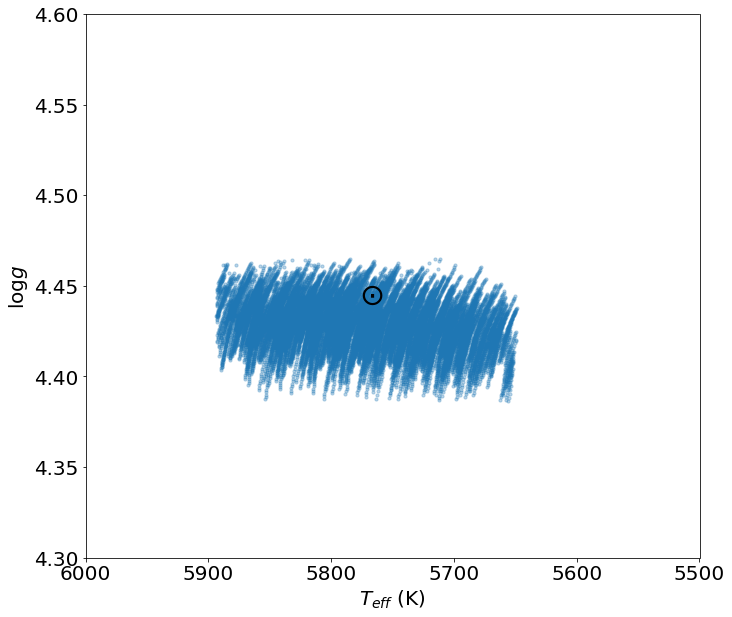

In [17]:
plt.scatter(starset0.effective_T, starset0.log_g, s = 10, alpha = 0.3)
plt.text(5777,4.44, r'$\odot$', fontsize = 30)
plt.xlim(6000,5500)
plt.ylim(4.3,4.6)
plt.xlabel(r'$T_{eff}$ (K)')
plt.ylabel(r'$\log g$')

# We plot models around the sun within the range of Teff = 5777±300K and logg = 4.44±0.3dex on the Teff-logg diagram. This model grid is fine enough to fit the sun's atomosphere. However, if we inspect the model frequencies as below: 

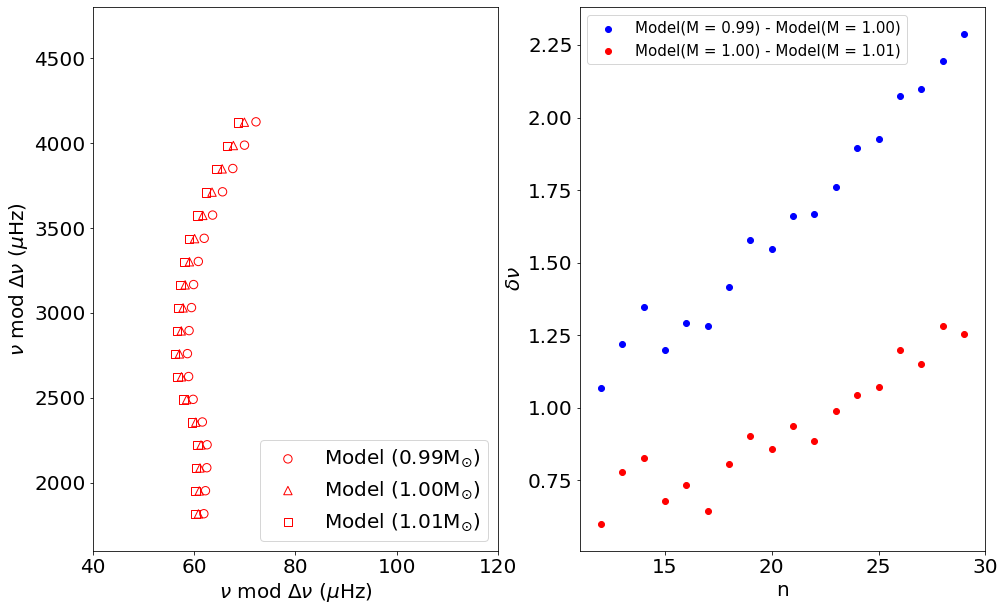

In [18]:
bestset = starset0.copy()
bestset['lk_mean_density'] = np.exp(-(bestset.mean_density - 1.0005)**2.0/2/0.0001)

obsnu_0_n_number = [i for i in range(12,30)]
obsnu_0_n_text = ['nu_0_%s' % s for s in obsnu_0_n_number]

model1 = bestset[(
                  (bestset.initial_mass == 0.99) 
                  & (bestset.initial_Yinit == 0.26)
                  & (bestset.initial_MLT == 2.1)
                  & (bestset.initial_feh == 0.0)
                 )].reset_index()

model2 = bestset[(
                  (bestset.initial_mass == 1.00) 
                  & (bestset.initial_Yinit == 0.26)
                  & (bestset.initial_MLT == 2.1)
                  & (bestset.initial_feh == 0.0)
                 )].reset_index()

model3 = bestset[(
                  (bestset.initial_mass == 1.01) 
                  & (bestset.initial_Yinit == 0.26)
                  & (bestset.initial_MLT == 2.1)
                  & (bestset.initial_feh == 0.0)
                 )].reset_index()

fig, (ax, axx) = plt.subplots(1,2,figsize = (16,10))
obsdnu = 135.1
# frequencies on the ED
ax.scatter(model1.loc[model1.lk_mean_density.argmax(),obsnu_0_n_text] % obsdnu, model1.loc[model1.lk_mean_density.argmax(),obsnu_0_n_text], label = r'Model (0.99M$_{\odot}$)',facecolors='none',edgecolors='r', s = 70)
ax.scatter(model2.loc[model2.lk_mean_density.argmax(),obsnu_0_n_text] % obsdnu, model2.loc[model2.lk_mean_density.argmax(),obsnu_0_n_text], label = r'Model (1.00M$_{\odot}$)', marker = '^',facecolors='none',edgecolors='r', s = 70)
ax.scatter(model3.loc[model3.lk_mean_density.argmax(),obsnu_0_n_text] % obsdnu, model3.loc[model3.lk_mean_density.argmax(),obsnu_0_n_text], label = r'Model (1.01M$_{\odot}$)', marker = 's',facecolors='none',edgecolors='r', s = 70)
ax.set_xlim(40, 120)
ax.set_ylim(1600,4800)
ax.legend(loc = 'lower right')
ax.set_xlabel(r'$\nu$ mod $\Delta\nu$ ($\mu$Hz)')
ax.set_ylabel(r'$\nu$ mod $\Delta\nu$ ($\mu$Hz)')

# plot differences 
axx.scatter(obsnu_0_n_number,
            model1.loc[model1.lk_mean_density.argmax(),obsnu_0_n_text] - model2.loc[model2.lk_mean_density.argmax(),obsnu_0_n_text],
            c = 'b', label = 'Model(M = 0.99) - Model(M = 1.00)'
           )
axx.scatter(obsnu_0_n_number,
            model2.loc[model2.lk_mean_density.argmax(),obsnu_0_n_text] - model3.loc[model3.lk_mean_density.argmax(),obsnu_0_n_text],
            c = 'r', label = 'Model(M = 1.00) - Model(M = 1.01)'
           )
axx.set_xlabel('n')
axx.set_ylabel(r'$\delta\nu$')
axx.legend(fontsize = 15)

# It can be seen that the frequency resolution (at the same mean density but different input mass) is relatively loose. Compared to the typical observed uncertainty (below 0.5microHz), this model uncertainty is significantly large. If we fit model to data without considering any model systematics, we will apparently obtain unreliable estimates.  

# Let us use a fake stars to see demostrate fitting with an under sampled grid. 

- The fake star is computed with the same input physics but the input fundemental parameters (mass, metallicity, etc.) are off-grid. 

- We use three classical constraints with a typical uncertainty as ±50K for Teff, ±0.1dex for logg, and ±0.1 dex for [Fe/H]. 

- we assume a constant observed uncertainty which is ± 0.5 microHz

True parameters for the fake star
Teff =  [5778.49441196]
logg =  [4.44671953]
[Fe/H] =  [-0.04593061]
M =  [1.01]
Y =  [0.26]
MLT =  [1.9]
tau =  [2.83998063]
R =  [0.9948225]
rho =  [1.02585167]
Dnu =  137.1184014457508
nu_max =  3147.9299095471406
nu =  [1837.07619624 1973.50761286 2110.3754453  2247.5767735  2383.29544911
 2518.5279527  2653.84613507 2790.13350573 2927.27710762 3064.34244348
 3201.76128758 3339.1444485  3476.949473   3615.22368591 3753.71926587
 3892.59835504 4031.38587551 4170.50836074]


Text(0.5, 1.0, 'Observed mode frequency of a fake star')

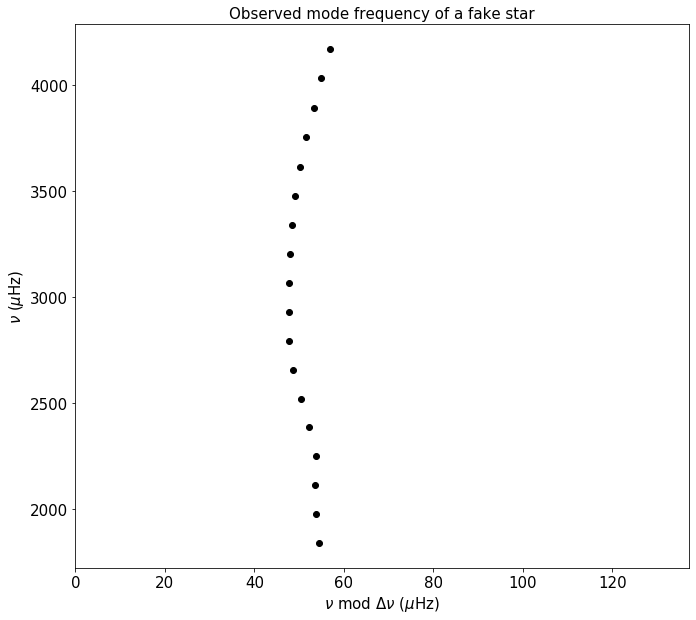

In [54]:
fakeset = pd.read_csv('models.csv', index_col = 0)
fakeset['log_age'] = np.log10(fakeset.star_age*1.0e9)
fakeset['mean_density'] = fakeset.star_mass/fakeset.radius**3.0
fakeset['dnu'] = 135.1*(fakeset.mean_density**0.5)
fakeset['numax'] = 3100.0 * 10**(fakeset.log_g - 4.44) * (fakeset.effective_T/5777.0)**(-0.5)

nuse = (
          (np.abs(fakeset.initial_mass - 1.01) <=0.005) 
        & (np.abs(fakeset.effective_T - 5778.49) <=1)
        & (np.abs(fakeset.log_g - 4.4467) <=0.0001)
        & (np.abs(fakeset.star_feh - 0.0) <=0.05)
       )
fakestar = fakeset[nuse].reset_index()

# observed constraints

obs_teff_e = 50.0
obs_logg_e = 0.1
obs_feh_e = 0.1

obs_teff = fakestar.effective_T.values 
# + np.random.normal(loc=0.0, scale=1.0, size=1)*obs_teff_e
obs_logg = fakestar.log_g.values 
# + np.random.normal(loc=0.0, scale=1.0, size=1)*obs_logg_e
obs_feh = fakestar.star_feh.values 
# + np.random.normal(loc=0.0, scale=1.0, size=1)*obs_feh_e

# The global seismic constraints

obs_dnu = fakestar.delta_nu_fit.values[0]
obs_numax = fakestar.numax.values[0]

# We use radial modes for n = 12 - 30 as observed mode frequencies

obsnu_0_n_number = [i for i in range(12,30)]
obsnu_0_n_text = ['nu_0_%s' % s for s in obsnu_0_n_number]

obs_nu0 = fakestar[obsnu_0_n_text].values
obs_nu0_e = np.full(shape = (len(obsnu_0_n_text)), fill_value = 0.5)

obs_nu0 = obs_nu0[0] 
# + np.random.normal(loc=0.0, scale=1.0, size=len(obs_nu0))*0.1

m,b = np.polyfit(obsnu_0_n_number,obs_nu0, 1) 

# truths of fundemantial inputs

cc = ['star_mass','radius','star_age','initial_Yinit', 'initial_MLT']
truths = fakestar[cc].values
truths = truths[0]


print('True parameters for the fake star')
print('Teff = ', fakestar.effective_T.values)
print('logg = ', fakestar.log_g.values)
print('[Fe/H] = ', fakestar.star_feh.values)
# 
print('M = ', fakestar.star_mass.values)
print('Y = ', fakestar.initial_Yinit.values)
print('MLT = ', fakestar.initial_MLT.values)
print(r'tau = ', fakestar.star_age.values)
print('R = ', fakestar.radius.values)
print(r'rho = ', fakestar.mean_density.values)
#
print('Dnu = ', m)
print('nu_max = ', obs_numax)
print('nu = ', obs_nu0)

plt.scatter(obs_nu0 % m, obs_nu0, c = 'k')
plt.xlim([0, m])
plt.xlabel(r'$\nu$ mod $\Delta\nu$ ($\mu$Hz)')
plt.ylabel(r'$\nu$ ($\mu$Hz)')
plt.title('Observed mode frequency of a fake star')

# Here we write a simple script to do MLE fitting for mode frequencies. Note that there is not surface term for the fake star

In [32]:
class smart_fit:
    '''
    '''
    
    def __init__(self):
        return None
    
    def mle(self, model, obs, obs_e):
        return -0.5*(model - obs)**2.0/obs_e**2.0
    
    def fit_modes(self, obs_nu, obs_nu_e, modeldf, nucolumns, lkcolumn):
        
        if lkcolumn in modeldf.columns:
            modeldf.loc[:,lkcolumn] = -1.0e99
        else:    
            modeldf.insert(loc = len(modeldf.columns), column = lkcolumn, value = -1.0e99,allow_duplicates=False) 
        
        for index, row in modeldf.iterrows():
            loglk = 0.0            
            model = row[nucolumns]
            loglk = self.mle(model, obs_nu, obs_nu_e)
            modeldf.loc[index, lkcolumn] = np.sum(loglk)
        return modeldf
sfit = sfit = smart_fit()

In [33]:
# Fit to classical constraints and obtain 'lk_spectro'
starset0['lk_effective_T'] = sfit.mle(starset0.effective_T, obs_teff, obs_teff_e)
starset0['lk_log_g'] = sfit.mle(starset0.log_g, obs_logg, obs_logg_e)
starset0['lk_feh'] = sfit.mle(starset0.star_feh, obs_feh, obs_feh_e)
starset0['lk_spectro'] = starset0['lk_effective_T'] + starset0['lk_log_g'] + starset0['lk_feh']

# Only select models that fits to classical constraints  
starset = starset0[starset0.lk_spectro >= -3.0]
# and we remove models that deviate too much from the obs
nuse = ( (np.median(obs_nu0 - starset[obsnu_0_n_text], axis = 1) < +0.02*obs_numax) &
         (np.median(obs_nu0 - starset[obsnu_0_n_text], axis = 1) > -0.02*obs_numax)
       )
starset = starset[nuse]
starset.index = range(len(starset))
starset

,csvname,filename,model_number,evol_stage,initial_mass,initial_feh,initial_Yinit,initial_MLT,star_mass,star_age,...,lk_effective_T,lk_log_g,lk_feh,lk_total,log_age,mean_density,dnu,numax,lk_spectro,lk_seismo_0
0,m1.0Y0.24FeH-0.1MLT2.3ov0.0dif1,profile610,758,1,1.00,-0.1,0.24,2.3,1.00,4.541005,...,-1.594348,-0.000162,-0.667263,0.155523,9.657152,1.024577,136.750067,3110.963762,-2.261774,-1.374361e+05
1,m1.0Y0.24FeH-0.1MLT2.3ov0.0dif1,profile611,759,1,1.00,-0.1,0.24,2.3,1.00,4.563743,...,-1.609990,-0.000314,-0.670826,0.153943,9.659321,1.022081,136.583421,3105.794421,-2.281130,-1.212467e+05
2,m1.0Y0.24FeH-0.1MLT2.3ov0.0dif1,profile612,760,1,1.00,-0.1,0.24,2.3,1.00,4.586462,...,-1.625631,-0.000517,-0.674387,0.152377,9.661478,1.019587,136.416668,3100.624807,-2.300534,-1.060645e+05
3,m1.0Y0.24FeH-0.1MLT2.3ov0.0dif1,profile613,761,1,1.00,-0.1,0.24,2.3,1.00,4.609161,...,-1.641255,-0.000769,-0.677946,0.150825,9.663622,1.017094,136.249775,3095.454111,-2.319971,-9.188862e+04
4,m1.0Y0.24FeH-0.1MLT2.3ov0.0dif1,profile614,762,1,1.00,-0.1,0.24,2.3,1.00,4.631842,...,-1.656861,-0.001073,-0.681504,0.149288,9.665754,1.014601,136.082736,3090.282081,-2.339438,-7.872027e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12601,m0.91Y0.32FeH0.2MLT2.3ov0.0dif1,profile677,825,1,0.91,0.2,0.32,2.3,0.91,6.976062,...,-0.061487,-0.035906,-1.455688,0.447631,9.843610,0.985207,134.097036,2964.060163,-1.553082,-1.000000e+99
12602,m0.91Y0.32FeH0.2MLT2.3ov0.0dif1,profile678,826,1,0.91,0.2,0.32,2.3,0.91,7.000347,...,-0.059793,-0.038208,-1.451605,0.448857,9.845120,0.982335,133.901404,2958.233522,-1.549605,-1.000000e+99
12603,m0.91Y0.32FeH0.2MLT2.3ov0.0dif1,profile679,827,1,0.91,0.2,0.32,2.3,0.91,7.024571,...,-0.058171,-0.040582,-1.447542,0.450055,9.846620,0.979469,133.705962,2952.417288,-1.546294,-1.000000e+99
12604,m0.91Y0.32FeH0.2MLT2.3ov0.0dif1,profile680,828,1,0.91,0.2,0.32,2.3,0.91,7.048732,...,-0.056613,-0.043027,-1.443500,0.451225,9.848111,0.976612,133.510774,2946.613210,-1.543140,-1.000000e+99


In [34]:
# Fit to mode frequencies and obtain 'lk_seismo_0' (0 for no model systematics)
starset = sfit.fit_modes(obs_nu0, obs_nu0_e, starset, obsnu_0_n_text, 'lk_seismo_0')

# We make a coner plot for four fundemental parameters.
- As it can be seen that, a few models stands out and probability distribution is not continuos.
- This is because the grid is significantly undersampled.

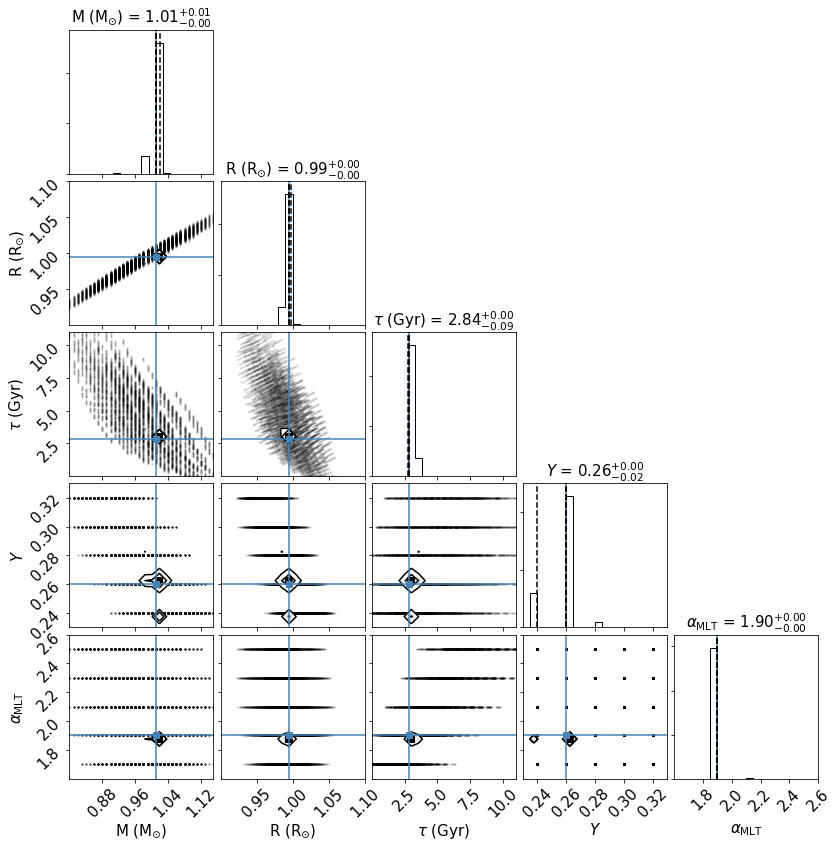

In [41]:
fontsize = 15

params = {'legend.fontsize': fontsize,
          'figure.figsize': (11, 10),
         'axes.labelsize': fontsize,
         'axes.titlesize':fontsize,
         'xtick.labelsize':fontsize,
         'ytick.labelsize':fontsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

figure = corner.corner(starset[cc], 
                       weights = np.exp(starset.lk_spectro + starset.lk_seismo_0),
                       bins = 20,
                       smooth=0.5,
                       truths = truths,
                       labels=[r"M (M$_{\odot}$)","R (R$_{\odot}$)", r"$\tau$ (Gyr)", r"$Y$", r"$\alpha_{\rm MLT}$"],
                       quantiles=[0.16, 0.5, 0.84],
                       range = [[0.8,1.15], [0.9,1.1] ,[0,11], [0.23,0.33], [1.6,2.6]],
                       show_titles=True, title_kwargs={"fontsize": 15})
# plt.text(-1.3,19, 'Fitting with white systematic noise',fontsize = 25)

# figure.savefig('fig_coner_.pdf')
plt.show()

# Now we consider the model systematics as a white noise 
- Acoording to the plot which illustrates the frequency change between gird points at given mean density, the model uncertianty is at the level of ~1.5microHz on average and it is also scaled by the frequency.  

- As a rough approximation, we adopt a white noise following a linear function of mode frequency, described as sigma_sys = 1.5nu/nu_max. 

In [48]:
# Now the mode frequency uncertainties become
nu0_e_sys = 1.5*obs_nu0/obs_numax
print('nu_e = ', np.sqrt(obs_nu0_e**2 + nu0_e_sys**2.0))

nu_e =  [1.00810649 1.06504515 1.12304695 1.18194538 1.24084586 1.30008094
 1.35982736 1.42042016 1.48176558 1.54340442 1.60549385 1.66782646
 1.73058276 1.79376202 1.85723115 1.92104687 1.98497497 2.04919779]


In [49]:
# We fit models to data again with these mode frequencies and use 'lk_seismo_wn' to represent the likelihood
starset = sfit.fit_modes(obs_nu0, np.sqrt(obs_nu0_e**2 + nu0_e_sys**2.0), starset, obsnu_0_n_text, 'lk_seismo_wn')

# We make a coner plot for four fundemental parameters again.
- Now, determinations looks more promising now, and it means the model systematics is neccesary when fitting with a model grid. 

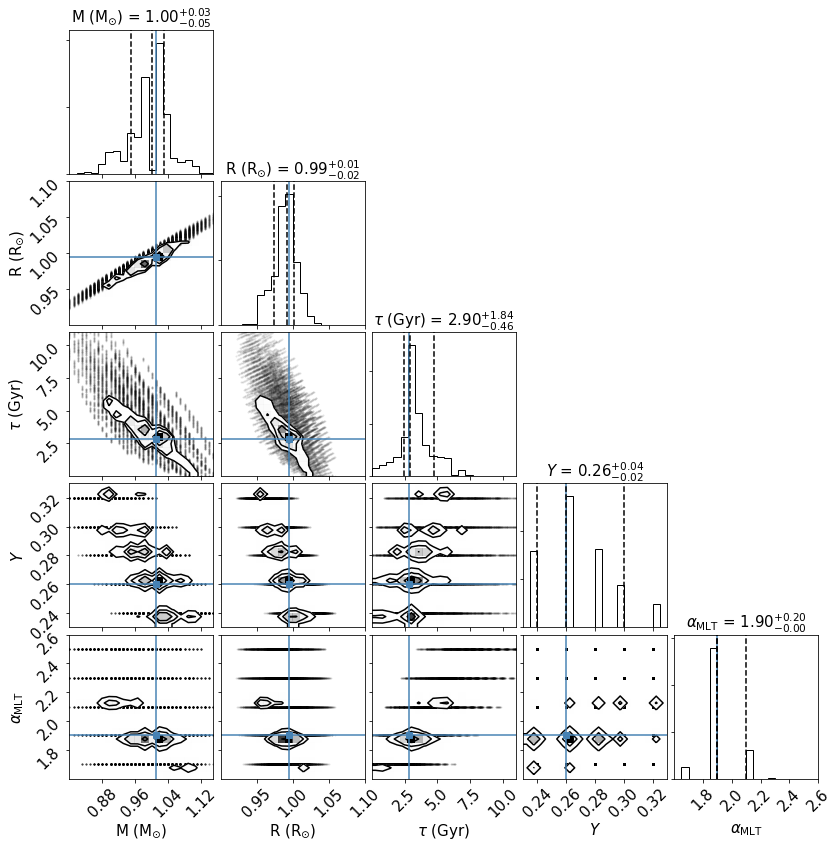

In [50]:
fontsize = 15

params = {'legend.fontsize': fontsize,
          'figure.figsize': (11, 10),
         'axes.labelsize': fontsize,
         'axes.titlesize':fontsize,
         'xtick.labelsize':fontsize,
         'ytick.labelsize':fontsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

figure = corner.corner(starset[cc], 
                       weights = np.exp(starset.lk_spectro + starset.lk_seismo_wn),
                       bins = 20,
                       smooth=0.5,
                       truths = truths,
                       labels=[r"M (M$_{\odot}$)","R (R$_{\odot}$)", r"$\tau$ (Gyr)", r"$Y$", r"$\alpha_{\rm MLT}$"],
                       quantiles=[0.16, 0.5, 0.84],
                       range = [[0.8,1.15], [0.9,1.1] ,[0,11], [0.23,0.33], [1.6,2.6]],
                       show_titles=True, title_kwargs={"fontsize": 15})
# plt.text(-1.3,19, 'Fitting with white systematic noise',fontsize = 25)
# figure.savefig('fig_coner_wn.pdf')
plt.show()

# Is white noise good for describing the model systematics, appearently not. 
- The model systematic model represents models which are not computed between the grid step.
- Even though we can not compute infinite models, it is known that oscllation mode frequencies of a certain model well correlate to each others according to the theory, while what the white noise predicts are mode frequencies with random bumping.

# We show a couple frequency sets sampled with the white noise below. As an comparison, we also demostrate those sampled with a correlated systematic noise model. 
- The correlated noise model is described as the square exponential kernel (covariance function) with a lengthscale equals to 3 times the large separation. The SE kernel can be integrated against most functions that we need to. Every function in its prior has infinitely many derivatives. The SE kernel only generates SMOOTH functions, saying that, the mode frequency can only change in a correlated way. The strenght of the correlation is determined by a free parameter called lengthscale, which describes the length of the 'wiggles' of the kernel.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: covariance is not positive-semidefinite.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: covariance is not positive-semidefinite.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: covariance is not positive-semidefinite.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: covariance is not positive-semidefinite.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: covariance is not positive-semidefinite.


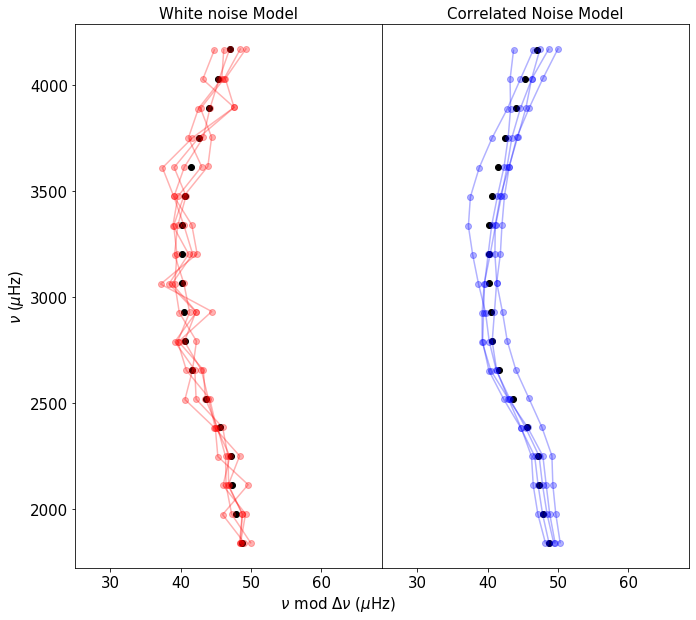

In [55]:
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.scatter(obs_nu0 % obs_dnu*0.95, obs_nu0, c = 'k')
ax1.set_xlim(25,0.5*obs_dnu)

nu = starset.loc[starset.lk_seismo_wn.argmax(), obsnu_0_n_text]

sigma = np.sqrt(obs_nu0_e**2 + nu0_e_sys**2.0)  
n = np.array(obsnu_0_n_number)
length_sys = 3.0*obs_dnu


for i in range(5):
    sys = np.random.randn(len(nu)) * sigma
    nu_ = nu
    mean = -5*(nu/3090.0)**3.0*0
    nu_ = nu_ + sys + mean
    ax1.plot((nu_ % obs_dnu*0.95), nu_, '-o',alpha = 0.3, c = 'r')
ax1.set_title('White noise Model')

ax2.scatter(obs_nu0 % obs_dnu*0.95, obs_nu0, c = 'k')
def SEKernel(x, y, sigma, length):
        return sigma**2 * np.exp(-0.5 * 
                        np.subtract.outer(x, y)**2 / length**2)
for i in range(5):
    Sigma = SEKernel(obs_nu0, obs_nu0, sigma, length_sys)
    sys = -np.random.multivariate_normal((n*0.00)**3, Sigma, size=1)[0]
    mean = -5*(nu/3090.0)**3.0*0
    nu_ = nu + sys  + mean
    ax2.plot(nu_ % obs_dnu*0.95, nu_, '-o',alpha = 0.3, c = 'b')


ax2.set_xlim(25,0.5*obs_dnu)
ax2.set_yticks([])
ax2.set_title('Correlated Noise Model')

ax1.set_xlabel(r'                                              $\nu$ mod $\Delta\nu$ ($\mu$Hz)')
ax1.set_ylabel(r'$\nu$ ($\mu$Hz)')

plt.subplots_adjust(wspace=0, hspace=None)
fig.savefig('fig_wm_cnm.pdf')

# As shown, the drawings from the correlated systematic noise model (CSNM) better represent model systematics given the fact that all radial modes are highly-correlated.  

# Now we could develope the CSNM with more details. The systematic noise can be understand as some predictions for off-grid mode frequenices.
- Inspecting the frequency change between grid points gives us some ideas about these predictions. 
- In general, frequency changes follow a smooth function (close to a linear function) of the frequency. 
- There is a secondary term corresponding to the signiture of helium glitch, which can be described as a damped sine function.
- we hence describe the noise model with two terms (two RBF kernels with different lengthscale and variance values).

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_new_instance()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  app.launch_n

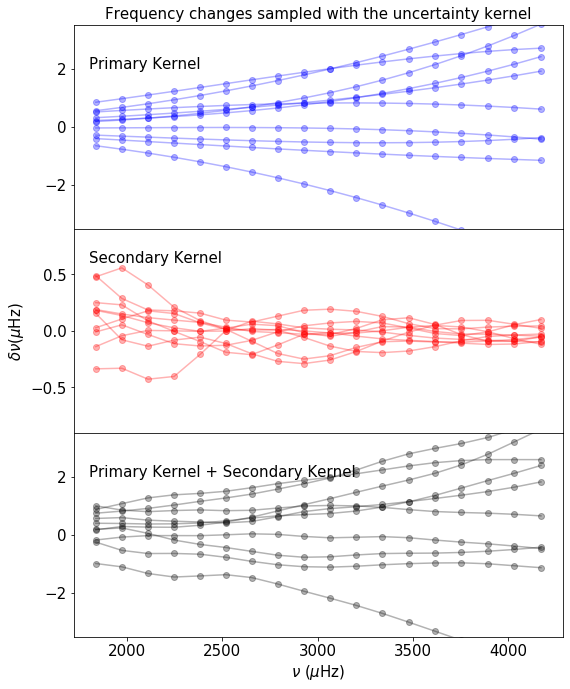

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (8,10))

nu = starset.loc[starset.lk_seismo_wn.argmax(), obsnu_0_n_text]


def SEKernel(x, y, sigma, length):
        return sigma**2 * np.exp(-0.5 * 
                        np.subtract.outer(x, y)**2 / length**2)
for i in range(10):
    Sigma = SEKernel(obs_nu0, obs_nu0, 1.5*(obs_nu0/obs_numax), 30.0*obs_dnu)
    sys = -np.random.multivariate_normal((n*0.00)**3, Sigma, size=1)[0] 
    ax1.plot(nu,  sys, '-o',alpha = 0.3, c = 'b')
    ax1.set_ylim(-3.5,3.5)
    
    Sigma = SEKernel(obs_nu0, obs_nu0, 0.1*(obs_numax/obs_nu0)**2.0, 2*obs_dnu)
    sys2 = -np.random.multivariate_normal((n*0.00)**3, Sigma, size=1)[0]
    ax2.plot(nu,  sys2, '-o',alpha = 0.3, c = 'r')
    ax2.set_ylim(-0.9,0.9)
    
    ax3.plot(nu,  sys+sys2, '-o',alpha = 0.3, c = 'k')
    ax3.set_ylim(-3.5,3.5)

ax1.set_title('Frequency changes sampled with the uncertainty kernel')
ax1.text(1800,2.0,'Primary Kernel',fontsize = 15)
ax2.text(1800,0.6,'Secondary Kernel',fontsize = 15)
ax3.text(1800,2.0,'Primary Kernel + Secondary Kernel',fontsize = 15)
ax2.set_ylabel(r'$\delta\nu$($\mu$Hz)')
ax3.set_xlabel(r'$\nu$ ($\mu$Hz)')

plt.subplots_adjust(left = 0.1, right = 0.95, bottom = 0.1, top = 0.95, wspace=0, hspace = 0)
fig.savefig('fig_generated_noise.pdf')

# Now update our fitting script by involving the correlated noise model based on the square exponiential kernel.

- There are two free parameters in the SE kernel function (see details on https://www.cs.toronto.edu/~duvenaud/cookbook/)
- The lengthscale l determines the length of the 'wiggles' in your function. In general, you won't be able to extrapolate more than units away from your data. 
- The output variance sigma^2 determines the average distance of your function away from its mean. Every kernel has this parameter out in front; it's just a scale factor.

# Determining the lengthscale

- In our case, the lengthscale represent the correlation between model frequencies. The SE kernel with a small lengthscale (e.g., l = Dnu0) gives a noise model similar to the white noise. A very large lengthscale gives a very smooth funcion which means that modes only change in a tigthly correlated way. We determine the lengthscale by inspecting the frequency differences between consecutive grid points at different dimissions.

- The patterm of frequency differencies between grid points is smooth but contents small 'wiggles' whose amplitude is approximately equals to or less than 0.5 microHz. 

- A proper noise model for this is a combination of a kernel with large lengthscale and variance (describing the general trend) plus another kernel with small lengthscale and variacne (describing the wiggles). 

- Here we determine the lengthscale for the two kernels. The 1st kernel should have a significantly large lengthscale because the frequency changes between grid points generally follow a linear function. We use a lengthscale = 100Dnu for the first kernel. The lengthscale of the 2nd kernel should match the length of 'wiggles'. howerver, the value to use need to be tested. 

- Here we test which lengthscales give the best fit to the data.

# Determining the sigma

- The output variance is the frequency resolution. We hence use what we obtianed above 

nu0_e_sys = obs_nu0/obs_numax 

as the sigma of SE kernel. 


# We update our fitting script by involving a correlated noise model

In [62]:
class smart_fit:
    '''
    
    '''
    
    def __init__(self):
        return None
    
    def mle(self, model, obs, obs_e):
        return -0.5*(model - obs)**2.0/obs_e**2.0
    
    def fit_modes(self, obs_nu, obs_nu_e, modeldf, nucolumns, lkcolumn):
        
        if lkcolumn in modeldf.columns:
            modeldf.loc[:,lkcolumn] = -1.0e99
        else:    
            modeldf.insert(loc = len(modeldf.columns), column = lkcolumn, value = -1.0e99,allow_duplicates=False) 
        
        for index, row in modeldf.iterrows():
            loglk = 0.0            
            model = row[nucolumns]
            loglk = self.mle(model, obs_nu, obs_nu_e)
            modeldf.loc[index, lkcolumn] = np.sum(loglk)
        return modeldf
    
#   fit with covirance function
    
    def fit_modes_cov(self, obs_nu = None, obs_nu_e = None, n_order = None,obs_dnu = None,
                       mean_sys = None,
                       sigma_e = None, length_e = None, 
                       sigma_u1 = None, sigma_u1_mlt = None, length_u1 = None,
                       sigma_u2 = None, length_u2 = None, 
                       modeldf = None, nucolumns = None, lkcolumn = None):
        
        if lkcolumn in modeldf.columns:
            modeldf.loc[:,lkcolumn] = -1.0e99
        else:    
            modeldf.insert(loc = len(modeldf.columns), column = lkcolumn, value = -1.0e99,allow_duplicates=False) 
        
        def SEKernel(x, y, sigma, length):
            return sigma**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / length**2)
        

        def cov_loglk(model, obs, obs_e, n_order):
            
#           We have four kernels to present the noises in 
#            i) model errors(the surface term), 
#           ii) frequency changes between grid for mass, matellicity, and helium faction 
#          iii) frequency changes between grid for the mixing-length parameter 
#           iv) changes in the glitch signiture between grid.

            Sigma = SEKernel(obs, obs, sigma_e, length_e) \
                  + SEKernel(obs, obs, sigma_u1, length_u1) \
                  + SEKernel(obs, obs, sigma_u1_mlt, length_u1) \
                  + SEKernel(obs, obs, sigma_u2, length_u2)
            
            mean_function = mean_sys
            freq_dif = model + mean_function - obs
            loglk = -0.5 * freq_dif.dot( np.linalg.inv(Sigma + np.identity(len(n_order))*obs_e**2.0)).dot(freq_dif.T) 
            return loglk

        '''
        '''
        for index, row in modeldf.iterrows():
                
            model_nu = row[nucolumns]
     
            modeldf.loc[index, lkcolumn] = cov_loglk(model_nu, obs_nu, obs_nu_e, n_order)
        return modeldf
    
sfit = smart_fit()



In [63]:
# Here the mean function is zero because there is no model errors in a fake star
mean_sys = obs_nu0*0.0

sigma_e = 0.0
length_e = 5.0*obs_dnu

sigma_u1 = 1.5*obs_nu0/obs_numax
sigma_u1_mlt = 0.0*(obs_nu0/obs_numax)
length_u1 = 20.0*obs_dnu

sigma_u2 = 0.1*(obs_numax/obs_nu0)**2.0
length_u2 = 2.0*obs_dnu



starset = sfit.fit_modes_cov(obs_nu = obs_nu0, obs_nu_e = obs_nu0_e,
                             n_order = np.array(obsnu_0_n_number),obs_dnu = obs_dnu, 
                             mean_sys = mean_sys, 
                             sigma_e = sigma_e, length_e = length_e, 
                             sigma_u1 = sigma_u1, sigma_u1_mlt = sigma_u1_mlt, length_u1 = length_u1,
                             sigma_u2 = sigma_u2, length_u2 = length_u2,
                             modeldf = starset, nucolumns = obsnu_0_n_text, lkcolumn = 'lk_seismo_scn')

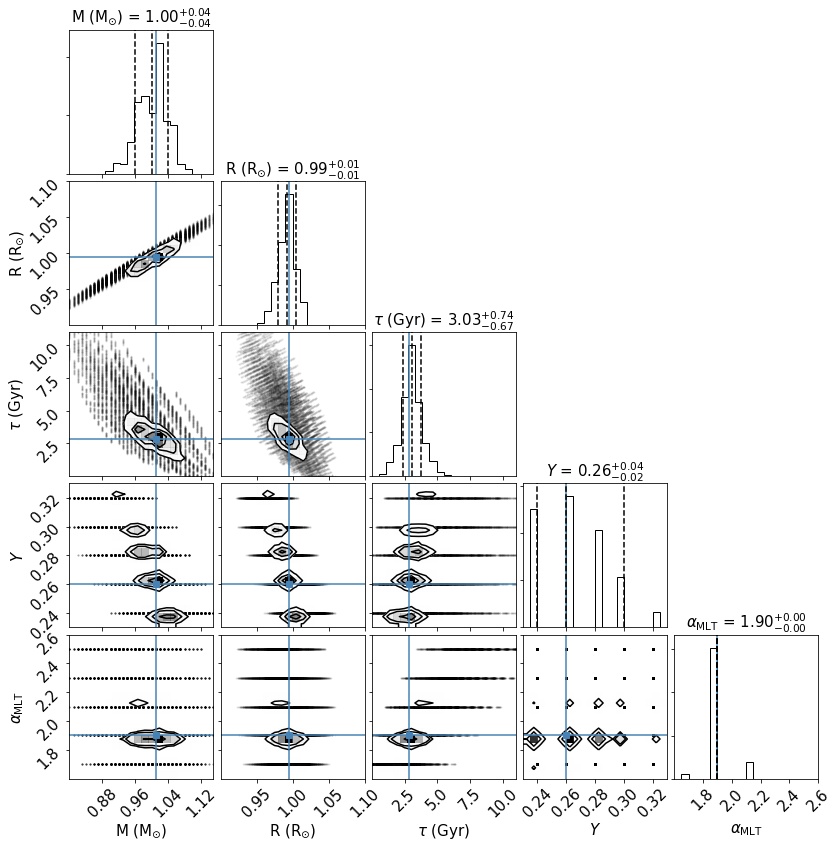

In [65]:
fontsize = 15

params = {'legend.fontsize': fontsize,
          'figure.figsize': (11, 10),
         'axes.labelsize': fontsize,
         'axes.titlesize':fontsize,
         'xtick.labelsize':fontsize,
         'ytick.labelsize':fontsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

cc = ['star_mass','radius','star_age','initial_Yinit', 'initial_MLT']

figure = corner.corner(starset[cc], 
                       weights = np.exp(starset.lk_spectro + starset.lk_seismo_scn),
                       bins = 20,
                        smooth=0.5,
                       truths = truths,
                       labels=[r"M (M$_{\odot}$)","R (R$_{\odot}$)", r"$\tau$ (Gyr)", r"$Y$", r"$\alpha_{\rm MLT}$"],
                       quantiles=[0.16, 0.5, 0.84],
                       range = [[0.8,1.15], [0.9,1.1] ,[0,11], [0.23,0.33], [1.6,2.6]],
                       show_titles=True, title_kwargs={"fontsize": 15})

# plt.text(-1.3,60, 'Fitting with correlated systematic noise',fontsize = 25)

# figure.savefig('fig_coner_scn.pdf')
plt.show()

# Fits with correlated systematic noise apperantly better recovers the truths of the fake star